In [315]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from distfit import distfit
%matplotlib inline

In [316]:
PD_COUNT = 100

MIN_PD = 300.0
MAX_PD = 1200.0
MIN_DIVIATION = -0.02  # Change to Deviation (spelling fix)
MAX_DIVIATION = +0.02

SAME_DELAYS = False
# SAME_DELAYS = True

In [345]:
def select_pairwise(input_array: np.array) -> np.array:
    x = np.array(np.meshgrid(input_array, input_array)).T.reshape(-1, 2)
    y = np.delete(x, np.arange(0, len(input_array)**2, len(input_array)+1), axis=0)
    return y


def get_pd_with_diviation(pd: float) -> float:
    return pd * (1 + np.random.normal(0, 0.01))
    # return pd * (1 + np.random.uniform(MIN_DIVIATION, MAX_DIVIATION))


def get_pd_with_diviation_new(size: int) -> np.array:
    return 1 + np.random.normal(0, 0.05 / 5, size=size)
    # return 1 + np.random.uniform(MIN_DIVIATION, MAX_DIVIATION, size=size)


def calc_bit_vector_new(pairs: np.array) -> np.array:
    kek = np.hsplit(pairs, 2)
    e1 = get_pd_with_diviation_new(len(pairs))
    e2 = get_pd_with_diviation_new(len(pairs))
    kek0 = kek[0].flatten() * e1
    kek1 = kek[1].flatten() * e2
    return (kek0 > kek1).astype(int)


def generate_propagation_delays(same_delays: bool, pd_count: int) -> np.array:
    if SAME_DELAYS:
        return np.full(pd_count, MIN_PD, dtype=np.float32)
    else:
        # return np.random.uniform(size=pd_count, low=MIN_PD, high=MAX_PD)
        return np.random.normal( 750, 450 / 3, size=pd_count)


def calc_uniformity(bit_vector: np.array) -> float:
    unique, counts = np.unique(bit_vector, return_counts=True)
    uniformity = counts[1] / bit_vector.size
    return uniformity


def calc_reliability(responses: list) -> float:
    ref = responses[0]
    n = len(responses)
    s = 0

    for i in range(1, len(responses)):
        s += distance.hamming(responses[i], ref) 

    return 1 - 1 / n * s




In [335]:
def plot_results(res: np.array):
    dfit = distfit(distr="norm")
    dfit.fit_transform(res)
    dfit.plot()


def analyze_unif():
    responses = []
    for _ in range(1000):
        pairs = select_pairwise(pd)
        bit_vector = calc_bit_vector_new(pairs)
        responses.append(bit_vector)
        
    total = np.zeros(len(responses), dtype=np.float32)
    for i in range(len(responses)):
        total[i] = calc_uniformity(responses[i])

    plot_results(total)


def analyze_reliability(fpga_num: int):
    total = np.zeros(fpga_num, dtype=np.float32)
    
    for cur_iter in range(fpga_num):
        pd = generate_propagation_delays(SAME_DELAYS, PD_COUNT)
        responses = []
        pairs = select_pairwise(pd)

        for i in range(300):
            bit_vector = calc_bit_vector_new(pairs)
            responses.append(bit_vector)
        
        total[cur_iter] = calc_reliability(responses)

    plot_results(total)


def analyze_uniqueness(fpga_num: int) -> float:
    total = 0

    fpga_resp = []
    for cur_iter in range(fpga_num):
        pd = generate_propagation_delays(SAME_DELAYS, PD_COUNT)
        pairs = select_pairwise(pd)
        bit_vector = calc_bit_vector_new(pairs)
        fpga_resp.append(bit_vector)

    for i in range(0, fpga_num - 1):
        for j in range(i + 1, fpga_num):
            total += distance.hamming(fpga_resp[i], fpga_resp[j])
    
    
    return 2 / (fpga_num * (fpga_num- 1)) * total

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 3477.97] [loc=0.500 scale=0.002]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 3477.97] [loc=0.500 scale=0.002]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.500022, scale:0.002009)


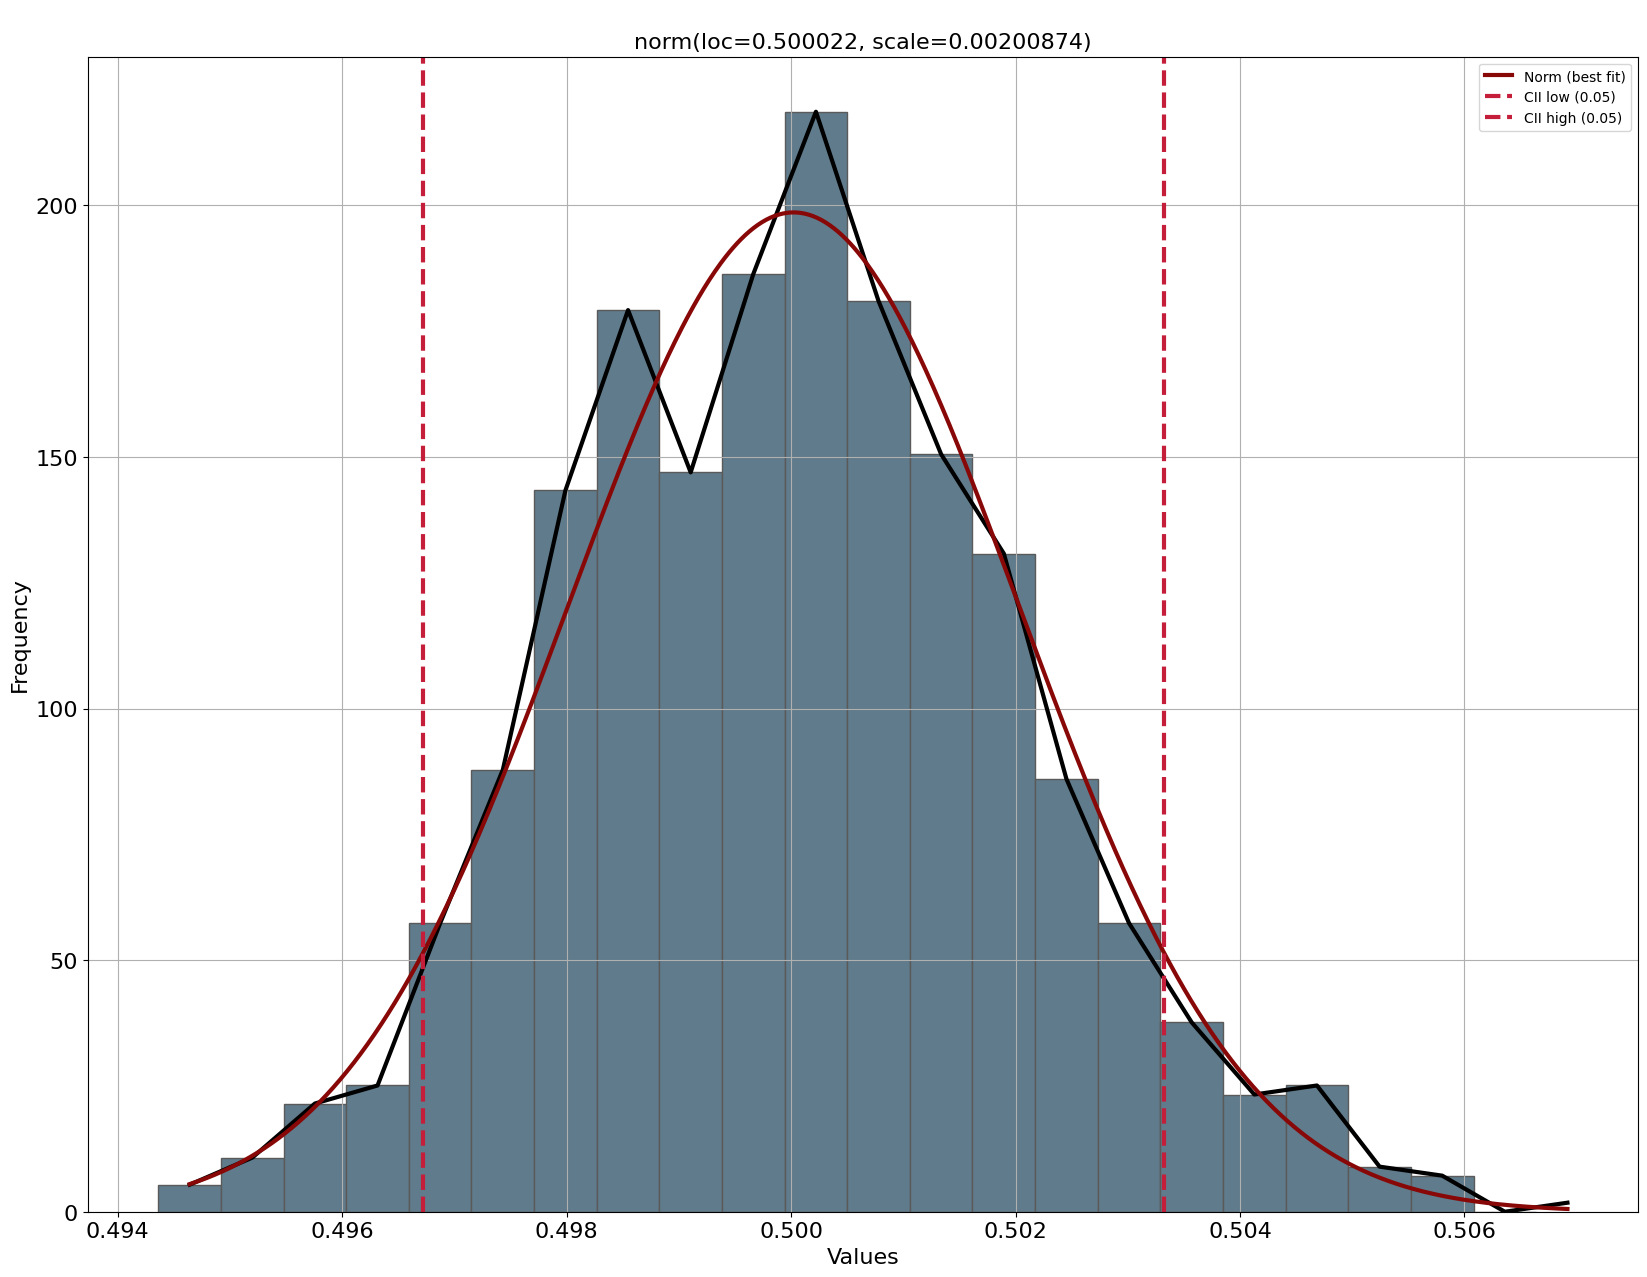

In [327]:
analyze_unif()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: 9749.97] [loc=0.978 scale=0.002]
[distfit] >INFO> [norm] [0.00 sec] [RSS: 9749.97] [loc=0.978 scale=0.002]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.977965, scale:0.002470)


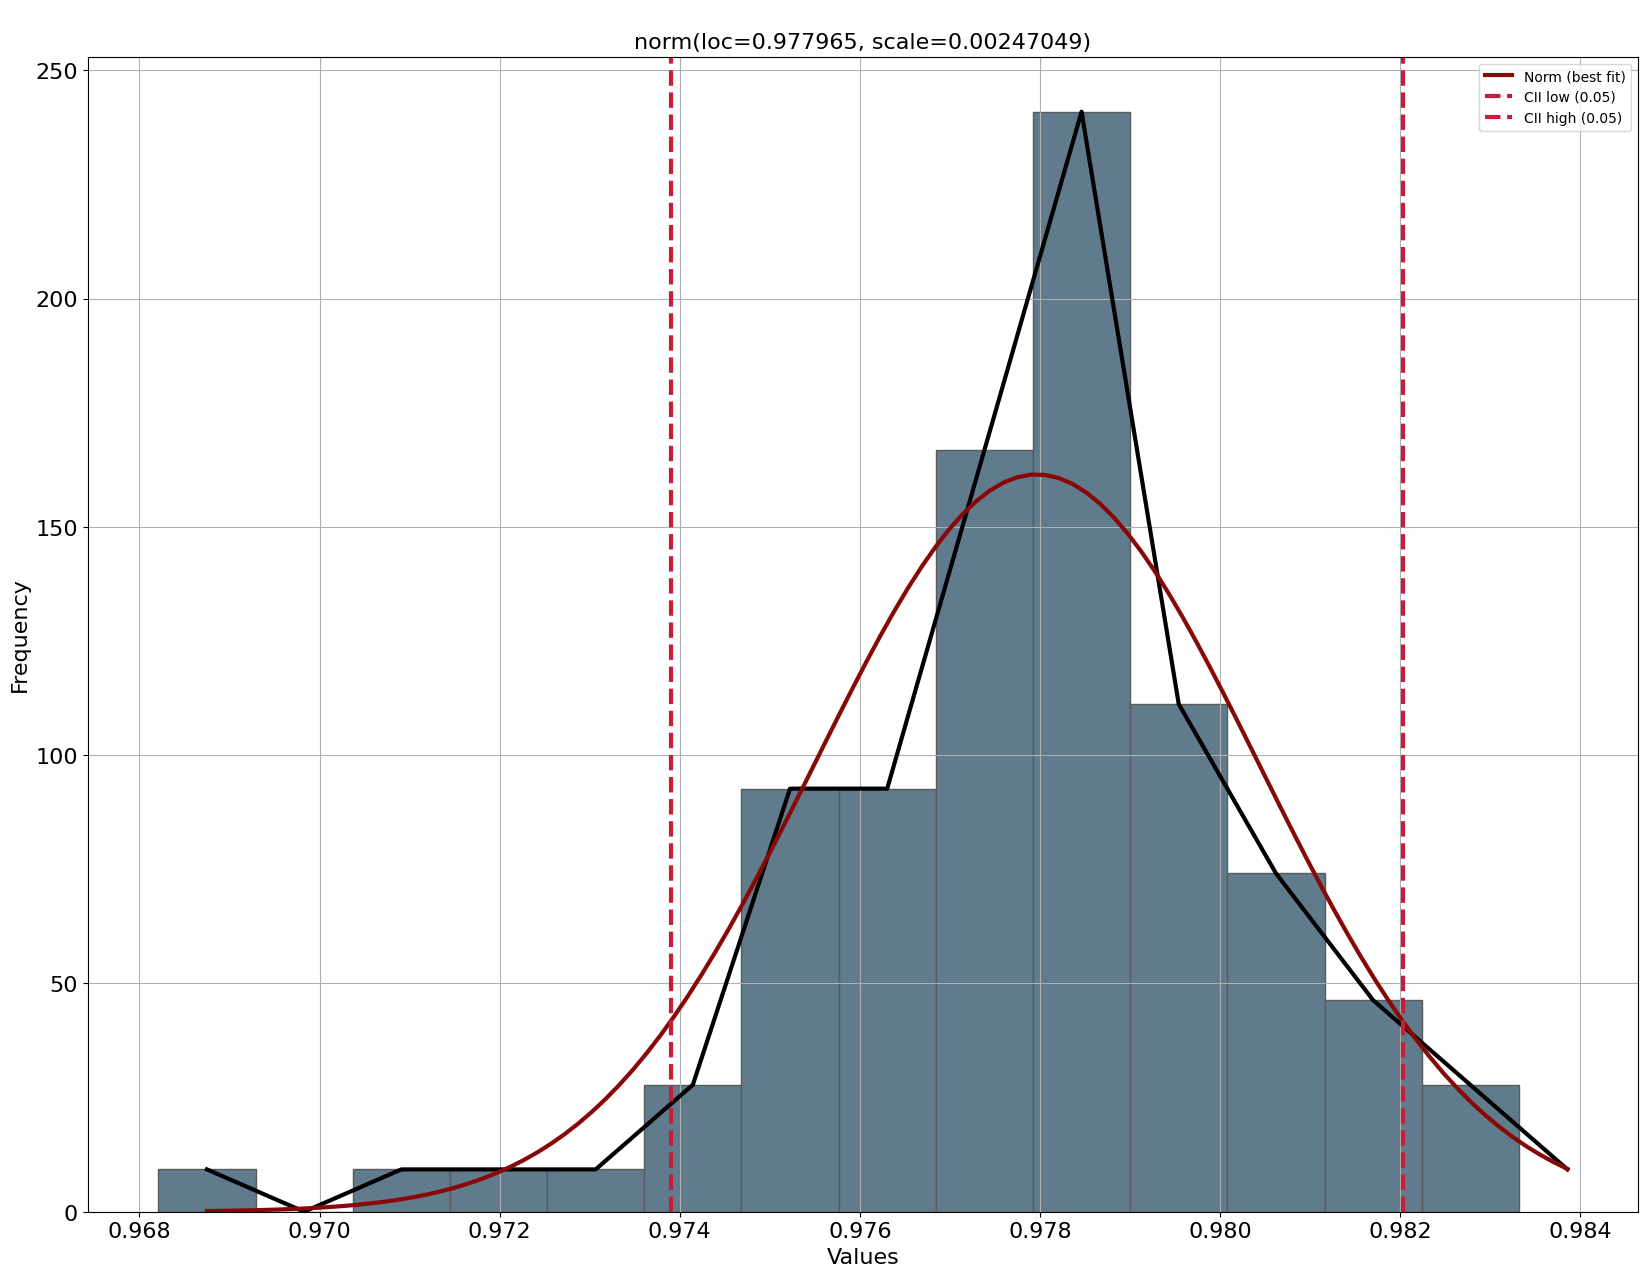

In [346]:
analyze_reliability(100)

In [332]:
analyze_uniqueness(100)

np.float64(0.4999829405162727)